In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import getpass
import statsmodels.api as sm

sns.set_style("white")

In [2]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="root",
                       passwd=getpass.getpass(),
                       db="olist")

········


OLIST rand a Black Friday campaign on Nov. 24th 2017

The analytics team is tasked to evaluated its success!

## Get weekly revenue data
| week_id | revenue |
|---------|---------|
| 2017-01-01| 234098|
|2017-01-08 | 3948209| 

timeframe: from beginning of 2017 until september 2018
- only want full weeks 

DATE_SUB (how you can subtract dates)

DAYOFWEEK

In [3]:
revenue_query = """
SELECT 
    DATE_SUB(DATE(o.order_purchase_timestamp), 
            INTERVAL DAYOFWEEK(DATE(o.order_purchase_timestamp)) - 1 DAY) AS week_id,
    SUM(oi.price)                                                         AS revenue
FROM orders o
    JOIN order_items oi
    ON o.order_id = oi.order_id
WHERE DATE(o.order_purchase_timestamp) > '2017-01-02'
    AND DATE(o.order_purchase_timestamp) < '2018-09-03'
    AND o.order_status = 'delivered'
GROUP BY week_id
ORDER BY week_id
"""

In [4]:
revenue = pd.read_sql(revenue_query, conn)

In [5]:
revenue.head()

,week_id,revenue
0,2017-01-01,2665.180000
1,2017-01-08,9165.069994
2,2017-01-15,21951.900026
3,2017-01-22,50239.989901
4,2017-01-29,66531.949844


In [6]:
revenue.dtypes

week_id     object
revenue    float64
dtype: object

In [7]:
revenue["week_id"] = pd.to_datetime(revenue["week_id"])

## Approach 1:
Compare the week of Black Friday to time period before

In [8]:
week = revenue.copy()

In [9]:
week = week.loc[week["week_id"].between(pd.to_datetime("2017-11-12"), pd.to_datetime("2017-11-19"))]

In [10]:
week

,week_id,revenue
45,2017-11-12,174613.250068
46,2017-11-19,371858.770386


In [11]:
week.loc[week["week_id"] == pd.to_datetime("2017-11-12"), "revenue"].values[0]
#test without values, doesn't work
#week.loc[week["week_id"] == pd.to_datetime("2017-11-12"), "revenue"][0]

174613.2500681877

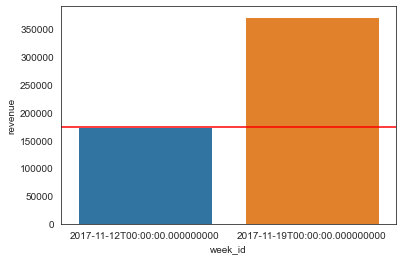

In [12]:
ax = sns.barplot(data=week, 
            x="week_id",
            y="revenue");
ax.axhline(week.loc[week["week_id"] == pd.to_datetime("2017-11-12"), "revenue"].values[0], color="r");

Calculate the difference

In [13]:
prev_week = week.loc[week["week_id"] == pd.to_datetime("2017-11-12"), "revenue"].values[0]
bf_week = week.loc[week["week_id"] == pd.to_datetime("2017-11-19"), "revenue"].values[0]

In [14]:
abs_diff = bf_week - prev_week
rel_diff = (bf_week / prev_week) - 1

In [15]:
#(bf_week / prev_week) - 1

In [16]:
print(f"""The revenue for the week including Black Friday increased by {round(rel_diff*100, 2)}% compared to the
week prior. Assuming the Black Friday promotion accounts for the entire difference, we were able to increase our 
revnue by {round(abs_diff, 2)}""")

The revenue for the week including Black Friday increased by 112.96% compared to the
week prior. Assuming the Black Friday promotion accounts for the entire difference, we were able to increase our 
revnue by 197245.52


Look at time series

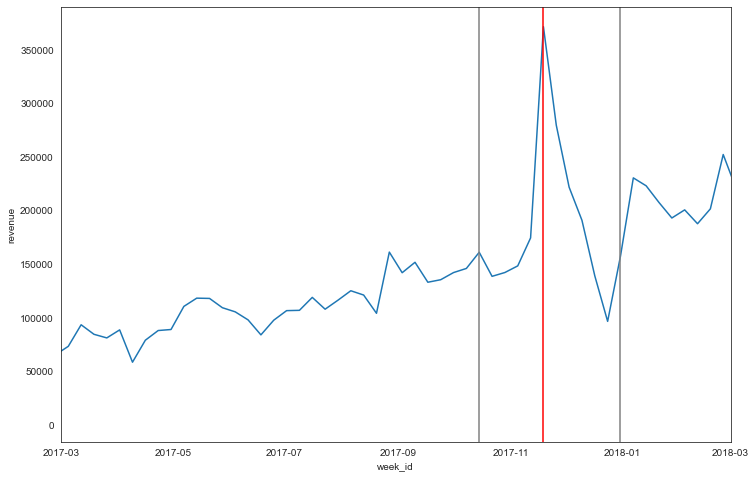

In [23]:
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=revenue, 
             x="week_id", 
             y="revenue", 
             ax=ax);

#removing data we don't need
ax.set_xlim((pd.to_datetime("2017-03-01")), pd.to_datetime("2018-03-01"));
ax.axvline(pd.to_datetime("2017-11-19"), color="r");

ax.axvline(pd.to_datetime("2017-10-15"), color="grey");
ax.axvline(pd.to_datetime("2017-12-31"), color="grey");

The graph suggests that revenue decreased in some time periods immediatly before and after the week of Black Friday, which indicated consumers may have changed their purchasing behavior. That is, some consumers may have postponed or preponed a purchase to save money. We can also see that revnue has probalby increase throughout the year of 2017.

We can 'bake in' these additional assumptions through considering a time range instead of just the week affected (change in behavior) and through estimating a trend line (trend). 

## Approach 2:
Establish baseline considering overall trend and change in behavior

In [19]:
rev_trend = revenue.loc[revenue["week_id"].between("2017-03-01", "2017-12-31")].copy().reset_index(drop=True)

In [21]:
rev_trend.head()

,week_id,revenue
0,2017-03-05,73356.079826
1,2017-03-12,93493.929724
2,2017-03-19,84591.779896
3,2017-03-26,81219.429926
4,2017-04-02,88718.030038


In [24]:
rev_trend_train = rev_trend.loc[rev_trend["week_id"].between("2017-03-01", "2017-10-15")].copy().reset_index(drop=True)

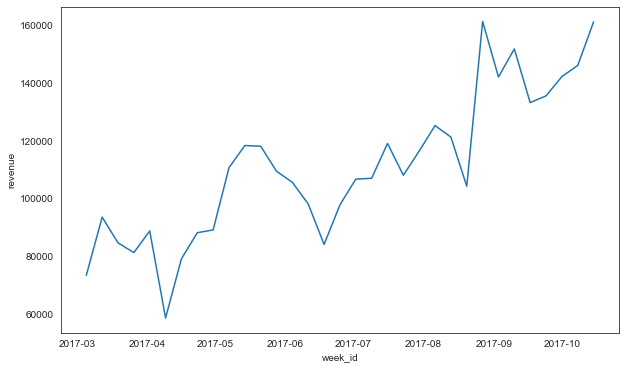

In [25]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=rev_trend_train, 
             x="week_id", 
             y="revenue", 
             ax=ax);

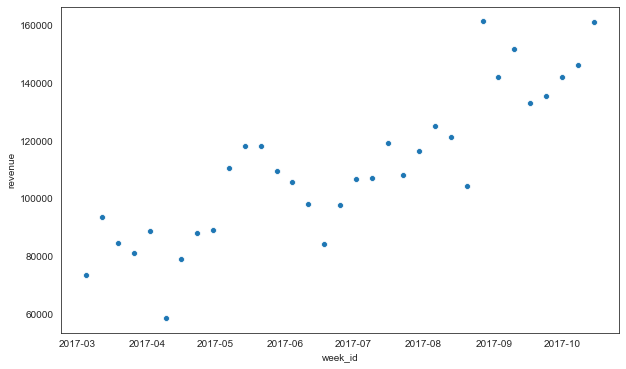

In [26]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(data=rev_trend_train, 
             x="week_id", 
             y="revenue", 
             ax=ax);

In [30]:
rev_trend_train = (rev_trend_train
                     .sort_values("week_id")
                     .assign(t=range(1, len(rev_trend_train)+1)))

In [31]:
rev_trend_train.head()

,week_id,revenue,t
0,2017-03-05,73356.079826,1
1,2017-03-12,93493.929724,2
2,2017-03-19,84591.779896,3
3,2017-03-26,81219.429926,4
4,2017-04-02,88718.030038,5


making sure our graphs look the same with `t` instead of `week_id`

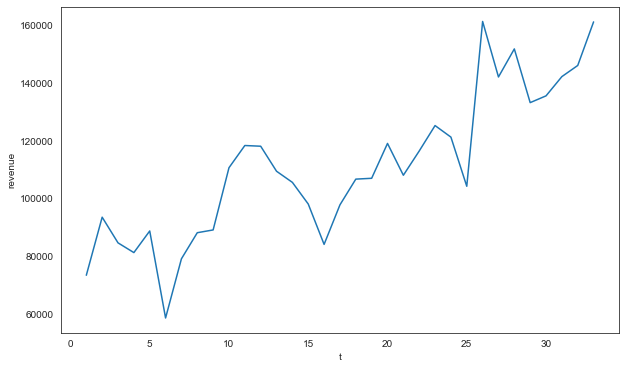

In [32]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=rev_trend_train, 
             x="t", 
             y="revenue", 
             ax=ax);

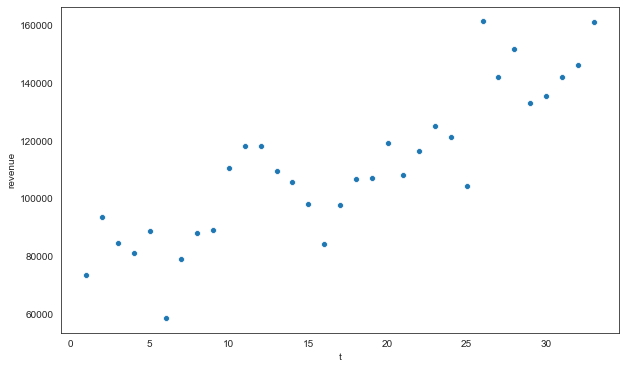

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(data=rev_trend_train, 
             x="t", 
             y="revenue", 
             ax=ax);

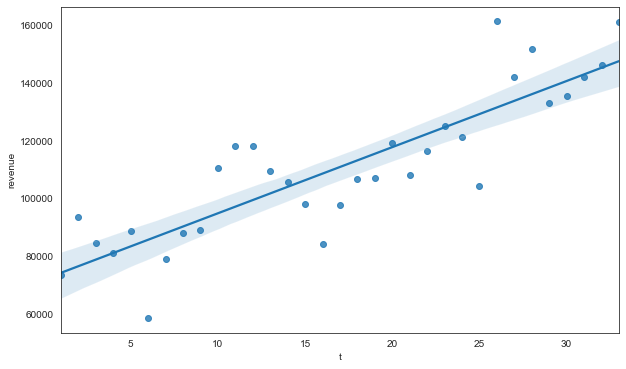

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

sns.regplot(data=rev_trend_train, 
             x="t", 
             y="revenue", 
             ax=ax);

Using Linear Regression to compute the fitted line

In [35]:
rev_trend_train = rev_trend_train.assign(const=1)

#rev_trend_train = sm.add_constant(rev_trend_train)

In [36]:
y = rev_trend_train["revenue"]
X = rev_trend_train[["const", "t"]]

In [37]:
lin_reg = sm.OLS(y, X)
results = lin_reg.fit()

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     88.13
Date:                Tue, 08 Sep 2020   Prob (F-statistic):           1.42e-10
Time:                        15:01:42   Log-Likelihood:                -359.30
No. Observations:                  33   AIC:                             722.6
Df Residuals:                      31   BIC:                             725.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.191e+04   4760.327     15.106      0.000    6.22e+04    8.16e+04
t           2293.4740    244.307      9.388      0.000    1795.207    2791.741
==============================================================================
Omnibus:                        0.177   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.915   Jarque-Bera (JB):                0.008
Skew:                           0.026   Prob(JB):                        0.996
Kurtosis:                       2.944   Cond. No.                         40.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

rev = 71910 + t * 2293.47

In [39]:
predicted_revenue = results.predict(X)
rev_trend_train = rev_trend_train.assign(predicted_rev=predicted_revenue)

In [40]:
rev_trend_train.head()

,week_id,revenue,t,const,predicted_rev
0,2017-03-05,73356.079826,1,1,74205.328346
1,2017-03-12,93493.929724,2,1,76498.802311
2,2017-03-19,84591.779896,3,1,78792.276275
3,2017-03-26,81219.429926,4,1,81085.750240
4,2017-04-02,88718.030038,5,1,83379.224204


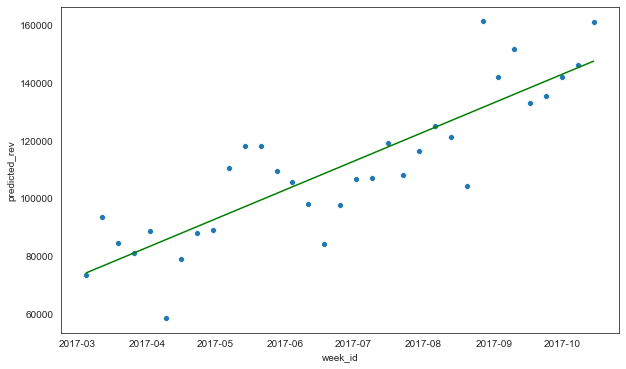

In [41]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(data=rev_trend_train, 
             x="week_id", 
             y="revenue", 
             ax=ax);

sns.lineplot(data=rev_trend_train, 
             x="week_id", 
             y="predicted_rev",
             color="green",
             ax=ax);

Predicts the revenue for the time periods affected by Black Friday

In [43]:
rev_trend = (rev_trend.assign(const=1,
                  t=range(1, len(rev_trend)+1)))

In [44]:
predicted_revenue_bf = results.predict(rev_trend[["const", "t"]])

In [45]:
rev_trend = rev_trend.assign(predicted_revenue=predicted_revenue_bf)

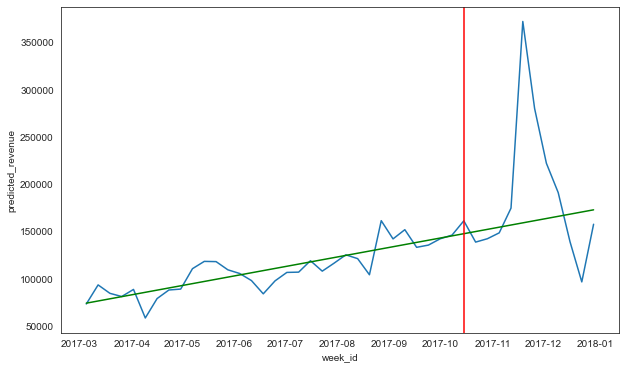

In [49]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=rev_trend, 
             x="week_id", 
             y="revenue", 
             ax=ax);

sns.lineplot(data=rev_trend, 
             x="week_id", 
             y="predicted_revenue",
             color="green",
             ax=ax);
ax.axvline(pd.to_datetime("2017-10-15"), color="red")

Calculate the differences betwee realized revenue and predicted revenue (baseline) and compute the sum

In [50]:
rev_bf = rev_trend.loc[rev_trend["week_id"] > "2017-10-15"]

In [52]:
rev_bf = rev_bf.assign(diff=rev_bf["revenue"] - rev_bf["predicted_revenue"])

In [54]:
abs_diff_trend = rev_bf["diff"].sum()
rel_diff_trend = (rev_bf["revenue"].sum() / rev_bf["predicted_revenue"].sum())-1

In [56]:
len(rev_bf)

11

In [57]:
print(f"""The increased revenue due to Black Friday increased by {round(rel_diff_trend*100, 2)}% 
for the duration of appox. {len(rev_bf)} weeks that we considered as impacted by our promotion.
Assuming the Black Friday promotion accounts for the entire difference, we were able to increase our 
revnue by {round(abs_diff_trend, 2)}""")

The increased revenue due to Black Friday increased by 16.2% 
for the duration of appox. 11 weeks that we considered as impacted by our promotion.
Assuming the Black Friday promotion accounts for the entire difference, we were able to increase our 
revnue by 287479.51


## Approach 3:
Establish a baseline considering overall quadratic trend and change in behavior. 

In [58]:
rev_qtrend_train = rev_trend_train[["week_id", "revenue", "const", "t"]].copy()
rev_qtrend = rev_trend[["week_id", "revenue", "const", "t"]].copy()

ax^2 + bx + c

In [60]:
#add quadratic time variable
rev_qtrend_train = rev_qtrend_train.assign(t2=rev_qtrend_train["t"]*rev_qtrend_train["t"])

In [61]:
y = rev_qtrend_train["revenue"]
X = rev_qtrend_train[["const", "t", "t2"]]

In [63]:
quad_reg = sm.OLS(y, X)
results_q = quad_reg.fit()

In [64]:
results_q.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     45.77
Date:                Tue, 08 Sep 2020   Prob (F-statistic):           7.69e-10
Time:                        15:41:57   Log-Likelihood:                -358.43
No. Observations:                  33   AIC:                             722.9
Df Residuals:                      30   BIC:                             727.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.911e+04   7350.031     10.763      0.000    6.41e+04    9.41e+04
t           1059.4376    996.698      1.063      0.296    -976.090    3094.966
t2            36.2952     28.438      1.276      0.212     -21.784      94.374
==============================================================================
Omnibus:                        0.850   Durbin-Watson:                   1.513
Prob(Omnibus):                  0.654   Jarque-Bera (JB):                0.231
Skew:                           0.168   Prob(JB):                        0.891
Kurtosis:                       3.234   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
results_q.predict(X)

0      80206.132508
1      81374.455692
2      82615.369249
3      83928.873179
4      85314.967482
5      86773.652158
6      88304.927207
7      89908.792629
8      91585.248423
9      93334.294591
10     95155.931132
11     97050.158045
12     99016.975331
13    101056.382991
14    103168.381023
15    105352.969428
16    107610.148206
17    109939.917357
18    112342.276881
19    114817.226778
20    117364.767047
21    119984.897690
22    122677.618705
23    125442.930094
24    128280.831855
25    131191.323990
26    134174.406497
27    137230.079377
28    140358.342630
29    143559.196256
30    146832.640255
31    150178.674627
32    153597.299371
dtype: float64

In [66]:
rev_qtrend = rev_qtrend.assign(t2=rev_qtrend["t"]*rev_qtrend["t"])

In [68]:
rev_qtrend = rev_qtrend.assign(predicted_rev=results_q.predict(rev_qtrend[["const", "t", "t2"]]))

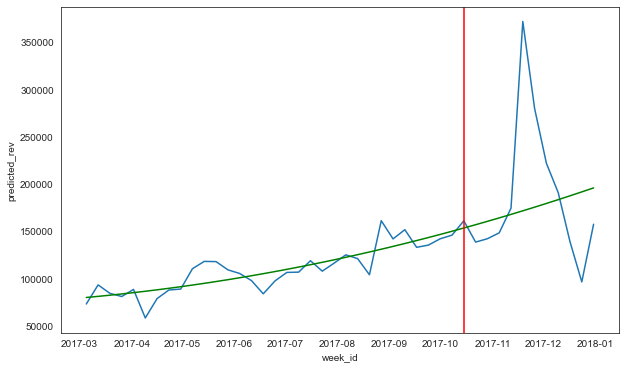

In [71]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=rev_qtrend, 
             x="week_id", 
             y="revenue", 
             ax=ax);

sns.lineplot(data=rev_qtrend, 
             x="week_id", 
             y="predicted_rev",
             color="green",
             ax=ax);
ax.axvline(pd.to_datetime("2017-10-15"), color="red")